In this notebook, I am plotting average contact frequencies over genomic intervals for four types of contacts. I will be using pairtools from open2c (https://github.com/open2c/pairtools)

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import bioframe as bf
import pairlib
import pairlib.scalings
import pairtools

In [2]:
# ignore log10(0) warnings
warnings.simplefilter("ignore", RuntimeWarning)

## Set plotting parameters

In [3]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 26,
                     'ytick.labelsize': 26, 
                     'axes.labelsize':26,
                     'font.size': 26})

## Define functions

In [4]:
def loadPairsGenerator(path, n=0.1):
    header, pairs_body = pairtools._headerops.get_header(
        pairtools._fileio.auto_open(path, 'r'))
    cols = pairtools._headerops.extract_column_names(header)
    frame = pd.read_csv(pairs_body, sep="\t", names=cols,
                        iterator=True,
                        chunksize=1000000)
    for i, chunk in enumerate(frame):
        if i % 100 == 0:
            print("Processing chunk:", i)
        yield chunk.sample(frac=n)


def loadPairs(path, n=0.1):
    gen = loadPairsGenerator(path, n=n)
    out = []
    for chunk in gen:
        out.append(chunk)
    return pd.concat(out)

## Load pairs

In [5]:
condition = 'deplProteinX'

directory = "/groups/gerlich/experiments/Experiments_005500/005512/pairs/ProteinX_exp5242"

pairs = {}
pairs["comp"] = loadPairs(f"{directory}.mapq_30.phred_30.right_muts_2.wrong_muts_0.comp.pairs.gz")
pairs["ref"] = loadPairs(f"{directory}.mapq_30.phred_30.right_muts_2.wrong_muts_0.ref.pairs.gz")
pairs["comp_ref"] = loadPairs(f"{directory}.mapq_30.phred_30.right_muts_2.wrong_muts_0.comp_ref.pairs.gz")
pairs["ref_comp"] = loadPairs(f"{directory}.mapq_30.phred_30.right_muts_2.wrong_muts_0.ref_comp.pairs.gz")

Processing chunk: 0
Processing chunk: 0
Processing chunk: 0
Processing chunk: 0


## Get chromosome arms

In [6]:
hg19_chromsizes = bf.fetch_chromsizes('hg19')
hg19_cens = bf.fetch_centromeres('hg19')
hg19_cens.set_index('chrom', inplace=True)
hg19_cens = hg19_cens.mid

hg19_arms = [arm
             for chrom in hg19_chromsizes.index
             for arm in ((chrom, 0, hg19_cens.get(chrom, 0)),
                         (chrom, hg19_cens.get(chrom, 0),
                          hg19_chromsizes.get(chrom, 0)))
             ]
hg19_arms = pd.DataFrame(hg19_arms, columns=['chrom', 'start', 'end'])

## Calculate scalings

In [7]:
scs = {rType: pairlib.scalings.compute_scaling(
    pairs[rType],
    hg19_arms,
    hg19_chromsizes
) for rType in ["comp", "ref", "comp_ref", "ref_comp"]}

## Calculate normalizing factor at 10 kb distance

In [8]:
distance = 10000

sc_agg = (scs["comp"][0]
          .groupby(['min_dist', 'max_dist'])
          .agg({'n_pairs': 'sum', 'n_bp2' : 'sum'})
          .reset_index())
 
n_pair = sc_agg[sc_agg['min_dist'] == distance]['n_pairs'].iloc[0]
bp2 = sc_agg [sc_agg ['min_dist'] == distance]['n_bp2'].iloc[0]
norm_factor = n_pair/bp2

## Caluclate normalized pair frequencies over genomic distances

In [9]:
pair_frequencies_dict = {}

for rType in ["comp", "ref", "comp_ref", "ref_comp"]:
    sc = scs[rType]
    sc_agg = (sc[0]
             .groupby(['min_dist', 'max_dist'])
             .agg({'n_pairs': 'sum', 'n_bp2' : 'sum'})
             .reset_index())
    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = (sc_agg.n_pairs / sc_agg.n_bp2)
    pair_frequencies = pair_frequencies/norm_factor
    mask = pair_frequencies>0
    pair_frequencies_dict[rType] = {
        'dist_bin_mids': dist_bin_mids[mask],
        'pair_frequencies': pair_frequencies[mask]}

## Plot trans scalings

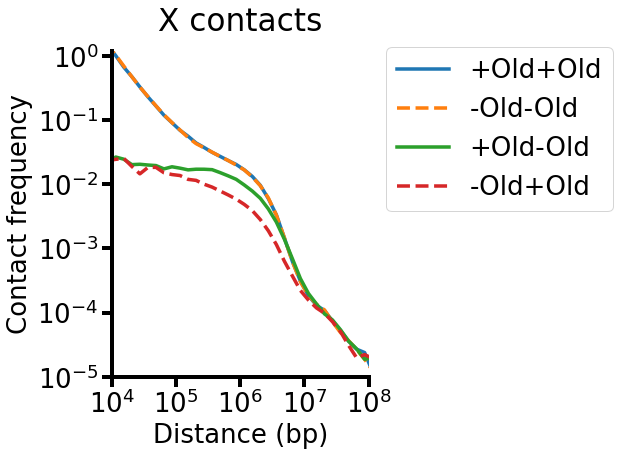

In [10]:
f, ax = plt.subplots(figsize=(8,6))

lsMap = {'comp': '-', 'ref': '--', 'comp_ref': '-', 'ref_comp': '--'}
rTypeMap = {'comp': '+Old+Old', 'ref': '-Old-Old','comp_ref': '+Old-Old', 'ref_comp': '-Old+Old'}

for rType in ['comp', 'ref', 'comp_ref', 'ref_comp']:
    
    ax.loglog(
        pair_frequencies_dict[rType]['dist_bin_mids'],
        pair_frequencies_dict[rType]['pair_frequencies'],
        label=rTypeMap[rType],
        linestyle = lsMap [rType],
        lw=3.5
    )
                           
plt.sca(ax)   
plt.gca().set_aspect(1.0)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().xaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=10))
plt.gca().yaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=10))
plt.tick_params('both', length=10, width=4, which='major')
plt.tick_params('both', length=80, width=2, which='minor')
plt.xlim(1e4,1e8)
plt.ylim(1e-5,1.2)
plt.ylabel('Contact frequency')
plt.xlabel('Distance (bp)')
plt.legend(bbox_to_anchor=(2, 1.05))
plt.title ('X contacts', pad = 20)

plt.show();